# A small 1D pic without Poisson
To try out the fake R model

In [51]:
import numpy as np
import scipy as sp
import astropy

import matplotlib.pyplot as plt
%matplotlib inline



from ipywidgets import IntProgress as prog
from IPython.display import display

%load_ext snakeviz


The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [52]:
#parameters
Nx = 100 #cell number
Lx = 1e-3 #System length
Npart = 50*Nx #particles number, in particle par cell

n = 1e17  #[m^-3]
dT = 1e-12 #time step

Np = 500000;  #Number of particle to create
Te = 20;     #[eV] Electron distribution temperature
me = 9.109e-31; #[kg] electron mass
q = 1.6021765650e-19; #[C] electron charge
kb = 1.3806488e-23;  #Blozman constant
eps_0 = 8.8548782e-12; #Vaccum permitivitty

Ti = 5 #[eV]
mi = 131*1.6726219e27 #[kg]

L_De = np.sqrt(eps_0*Te/(q*n))

In [53]:
def generate_maxw(T,m):
    import random
    v_Te = np.sqrt(q*T/m)

    W = 2
 
    
    while (W >= 1 or W <= 0):
        R1 = (random.random()*2 -1 )
        R2 = (random.random()*2 -1 )
        
        W = R1**2 + R2**2
    W = np.sqrt( (-2*np.log(W))/W)
        
    v = v_Te*R1*W
    return v

def velocity_maxw_flux(T,m):
    import random
    v_Te = np.sqrt(q*T/m)

    R = random.random()
    v = (v_Te*np.sqrt(-np.log(R)))
    return v

In [107]:
class particles:
    """a Class with enouth attribute and methode to deal with particles"""
    def __init__(self, Npart,T,m):
        
        self.T = T
        self.m = m
        self.Npart = Npart
        self.x = np.zeros(Npart)
        self.V = np.zeros(Npart)*3
        
        self.init_part()
        
    def init_part(self):
        """Generate uniforme particle, with maxwellian stuff"""
        
        from random import random
        self.x = np.array([random()*Lx for i in np.arange(Npart)])
        
        self.V = [[generate_maxw(self.T,self.m),generate_maxw(self.T,self.m),generate_maxw(self.T,self.m)] for i in np.arange(Npart)]
        self.V = np.array(self.V)
    
    def add_uniform_part(self):
        """Generate one uniforme particle, with maxwellian stuff"""
        
        from random import random
        self.x = np.append(self.x,random()*Lx)
        
        self.V = np.append(self.V,
                           [[generate_maxw(self.T,self.m),generate_maxw(self.T,self.m),generate_maxw(self.T,self.m)]],
                           axis=0)
        
    def add_flux_part(self):
        """Generate one particle, with maxwellian flux velocity.
        
        Position of the particle is with respect to 0, in the positive direction """
        
        from random import random
        self.V = np.append(self.V,
                           [[velocity_maxw_flux(self.T,self.m),velocity_maxw_flux(self.T,self.m),velocity_maxw_flux(self.T,self.m)]],
                           axis=0)
                           
        
        self.x = np.append(self.x,random()*self.V[-1,0]*dT)
        
        
        
        
class plasma:
    """a class with fields, parts, and method to pass from one to the other"""
    
    def __init__(self,Nx,Npart,n):
        
        self.history = {'Ie_w' : [],
                        'Ii_w' : [],
                        'Ie_c' : [],
                        'Ii_c' : []
                        }
        
        self.qf = n*Lx/(Npart)
        self.ele = particles(Npart,Te,me)
        self.ion = particles(Npart,Ti,mi)
        
        self.E = np.zeros((Nx+1,3))
        self.phi = np.zeros(Nx+1)
        self.ne = np.zeros((Nx+1))
        self.ni = np.zeros((Nx+1))
        self.rho = np.zeros((Nx+1))
        
        self.x_j = np.arange(0,Nx+1)*Lx/(Nx)
        self.dx = self.x_j[1]
        
    def pusher(self):
        """push the particles"""
        from scipy import interpolate
        
        for sign,part in zip([-1,1],[self.ele,self.ion]):
            E = [interpolate.interp1d(self.x_j,self.E[:,i]) for i in [0,1,2]]
            for i in [0,1,2]:
                try:
                    part.V[:,i] -= sign*q/me*dT*E[i](part.x)
                except:
                    print(part.x,part.V[:,0],Lx)
                    raise ValueError
            part.x += part.V[:,0] *dT
            
        self.boundary()
            
    def boundary(self):
        """look at the postition of the particle, and remove them if they are outside"""
        
        for key, part in zip(['Ie_w','Ii_w'],[self.ele,self.ion]):
            mask = part.x < Lx
            part.x = part.x[mask]
            part.V = part.V[mask,:]
            self.history[key].append(np.count_nonzero(mask==0))
            
        for key, part in zip(['Ie_c','Ii_c'],[self.ele,self.ion]):
            mask = part.x >0
            part.x = part.x[mask]
            part.V = part.V[mask,:]
            self.history[key].append(np.count_nonzero(mask==0))
            
        self.inject_particles(self.history['Ie_w'][-1],self.history['Ii_w'][-1])
            
        self.inject_flux(self.history['Ie_c'][-1],self.history['Ii_c'][-1])
        
    def inject_particles(self,Ne,Ni):
        """inject particle with maxwellian distribution uniformely in the system"""
        
        #Would be better to add an array of particle, not a single one
        for i in np.arange(Ne):
            self.ele.add_uniform_part()
        
        for i in np.arange(Ni):
            self.ion.add_uniform_part()
            
    def inject_flux(self,Ne,Ni):
        """inject particle with maxwellian distribution uniformely in the system"""
        
        #Would be better to add an array of particle, not a single one
        for i in np.arange(Ne):
            self.ele.add_flux_part()
            self.ele.V[-1,0] *= -1
            self.ele.x[-1] *= -1
            self.ele.x[-1] += Lx
        
        for i in np.arange(Ni):
            self.ion.add_flux_part()
            self.ion.V[-1,0] *= -1
            self.ion.x[-1] *= -1
            self.ion.x[-1] += Lx
        
    def compute_rho(self):
        """Compute the plasma density via the invers aera method"""
        
        
        for n, part in zip([self.ne,self.ni],[self.ele,self.ion]):
            n[:] = 0
            for i in np.arange(part.Npart):
                try:
                    j = np.argwhere(self.x_j>=part.x[i])[0][0]
                except IndexError:
                    print(part.x[i])
                    j = Nx
                
                n[j-1] += (pla.x_j[j] - part.x[i])
                n[j] += (part.x[i] - pla.x_j[j-1])
        
        self.ni /= self.dx**2*self.qf; self.ne /= self.dx**2*self.qf
        self.rho = self.ni - self.ne
        self.rho *= q
        

    def solve_poisson(self):
        """solve poisson via the Thomas method :
        
        TO VALIDATE !!!!
        
        
        A Phi = -rho/eps0 
        
        """
        
        di = self.rho/eps_0
        
        bi = - np.ones(self.Nx+1)
        bi[1:-2] *= 2
        
        ai, ci = np.ones(self.Nx+1), np.ones(self.Nx+1)
        
        ciprim = ci
        ciprim[0] /= bi[0]
        for i in np.arange(1,self.Nx+1):
            ciprim[i] /= bi[i] - ai[i]*ciprim[i-1]
        
        diprim = di
        diprim[0] /= bi[0]
        
        for i in np.arange(1,self.Nx+1):
            diprim[i] -= ai[i]*diprim[i-1]
            diprim[i] /= bi[i] - ai[i]*ciprim[i-1]
        
        self.phi[-1] = diprim[-1]
        for i in np.arange(self.Nx,0):
            self.phi[i] = diprim[i] - ciprim[i]*self.phi[i+1]
            
#        #Poisson finished

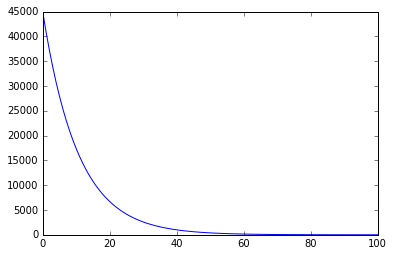

In [112]:
#Generate plasma
Npart = 100*Nx
pla = plasma(Nx,Npart,n)
#fix Electric field profile
pla.E[:,0] = 45e3*np.exp(-pla.x_j/(L_De))
pla.compute_rho()
plt.plot(pla.E)

In [ ]:
#plt.hist(pla.ele.x,label="start",bins=Nx);
Nt = 500
n_av = 100
a = 1.2
dT = 1e-10 #time step
plt.plot(pla.ne);

for i in np.arange(Nt):
    pla.pusher()
    pla.compute_rho()
    
    if i > 1 and i%n_av ==0:
        ie = pla.history["Ie_w"][-n_av:]
        ii = pla.history["Ii_w"][-n_av:]
        if ie > ii :
            print(i,"times a")
            pla.E[:,0] *= a
        else:
            print(i,"divied by a")
            pla.E[:,0] /= a
    
        plt.plot(pla.ne);


100 times a
200 times a
300 times a
400 times a


In [93]:
np.argwhere(pla.x_j>pla.ele.x[i])

88

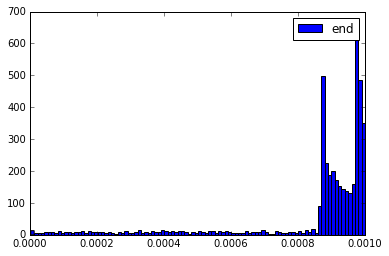

In [80]:
plt.hist(pla.ele.x,label="end",bins=Nx);
plt.legend()